In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read in data

This tutorial assumes that you already have a set of functional connectivity matrices (at least one per subject -- maybe more than one if you're interested in investigating how FC measured during different task conditions might impact behavioral prediction, as we do in this notebook).

For calculating FC matrices, first you need to choose a parcellation atlas. I tend to use the Shen 268-node atlas, which I like because atlases in the 200-300 range tend to have nodes small enough to accurately reflect local cortical activity, but not so small that effects are dominated by slight differences in functional anatomy (i.e., registration) across subjects. Also, unlike some atlases, the Shen atlas covers the whole brain, not just the neocortex (gotta show those subcortical and cerebellar areas some love!). But in reality, there's no perfect parcellation, and I see it as more of a dimensionality reduction step than a "ground truth" of brain organization. It's always a good idea to make sure your results are relatively robust to the choice of parcellation.

Once you have a parcellation and preprocessed fMRI data for each subject, it's pretty easy to make matrices. You can do it in AFNI with the command `3dROIstats`, for example. Pretty much any other fMRI software will have a way to do it too. 

For purposes of the code in this notebook, matrices should be stored as .txt or .csv files in a directory called "fc_data". Each filename should at minimum contain the subject ID as the first part of the string; e.g., for HCP data, the matrix for subject '100206' would be stored in a file called '100206_{label}.txt', where "label" is some condition label (e.g., '100206_REST.txt').

First let's set the directory structure:

In [2]:
top_dir = Path("./")
data_dir = top_dir/"fc_data/"

You should also have a list of subject IDs that you want to use stored as a .txt or a .csv file with one subject ID per line. 

This tutorial uses data from the Human Connectome Project (HCP). There are more than 1,200 subjects in the whole 3T dataset, each scanned twice at rest and once during each of seven different cognitive tasks. Lots of data! However, this 1,200 number consists of many twins (monozygotic and dizygotic) and siblings. This could be a confound for our purposes, since we might expect both functional connectivity and behavior to be more similar between pairs of twins and siblings than for unrelated subjects for any number of reasons. If we wanted to work with the full dataset, we would need to take family structure into account when performing our train-test splits (i.e., we would need to make sure that a subject in the test set never had a sibling in the training set, as this could give the model an unfair advantage).

To keep things simple, here we'll focus on a subsample of n = 337 subjects who are not related to one another.

We'll read this in here:

In [3]:
subj_list = pd.read_csv('unrelated_subIDs_n337.txt', header=None)
subj_list = np.array(subj_list, dtype=str).flatten()

This tutorial also assumes that you have a set of behavioral measures for each subject that are stored separately from the FC data, in a .csv file with subjects along the rows and behavioral measures along the columns. Here we read in a table containing all of the unrestricted behavioral data that was gathered on these HCP participants. (The restricted data, which contains things like DSM-style diagnostic interviews, questions about substance use, etc., requires signing a Data Use Agreement). 

We'll read in the behavioral data here:

In [4]:
all_behav_data = pd.read_csv('unrestricted_behav_data_n337.csv', dtype={'Subject': str})
all_behav_data.set_index('Subject', inplace=True)
print(all_behav_data.shape)
all_behav_data.head()

(337, 581)


,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
100206,S900,Q11,M,26-30,True,1,1,4,100,True,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
100610,S900,Q08,M,26-30,True,2,1,4,100,True,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
101006,S500,Q06,F,31-35,True,2,2,4,100,True,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
101309,S500,Q06,M,26-30,True,1,1,4,100,True,...,5.2,122.25,110.45,0.0,38.6,106.39,104.39,1.80,0.0,1.80
101915,Q3,Q04,F,31-35,True,2,2,4,100,True,...,4.4,96.87,77.61,0.0,38.6,112.11,111.70,1.84,1.0,1.80


Below we define a function for reading in individual-subject connectivity matrices:

In [5]:
def read_in_matrices(subj_list, file_suffix=None, data_dir=data_dir, zscore=False):
    """
    Reads in a set of individual-subject connectivity matrices stored in data_dir,
    
    Returns a dataframe that is subjects x edges (by vectorizing the upper triangle of each FC matrix).
    
    Assumes:
    - each matrix is stored in a separate file beginning with the subject ID, and
    - matrices are symmetric (squareform); i.e., for a parcellation with 268 nodes, matrices should be 268 x 268
    """
    
    all_fc_data = {}
            
    for subj in subj_list:
        # try to find this subject's matrix
        if file_suffix:
            file = [f for f in os.listdir(data_dir) if subj in f and file_suffix in f]
        else:
            file = [f for f in os.listdir(data_dir) if subj in f]
            
        # make sure there is one and only one file    
        if len(file) ==0:
            raise ValueError("No data found for subject {}".format(subj))
        if len(file) >1:
            raise ValueError("More than one matrix found for subject {}! Specify a suffix?".format(subj))
        
        # read it in and make sure it's symmetric and has reasonable dimensions
        tmp = np.loadtxt(data_dir / file[0])
        assert tmp.shape[0]==tmp.shape[1]>1, "Matrix seems to have incorrect dimensions: {}".format(tmp.shape)
        
        # take just the upper triangle and store it in a dictionary
        if ~zscore:
            all_fc_data[subj] = tmp[np.triu_indices_from(tmp, k=1)]
        if zscore:
            all_fc_data[subj] = sp.stats.zscore(tmp[np.triu_indices_from(tmp, k=1)])
        
    # Convert dictionary into dataframe
    all_fc_data = pd.DataFrame.from_dict(all_fc_data, orient='index')
    
    return all_fc_data

Let's read in the resting-state FC matrices for each subject in subj_list:

In [6]:
all_fc_data = read_in_matrices(subj_list, file_suffix='REST')

In [7]:
print(all_fc_data.shape)
all_fc_data.head()

(337, 35778)


,0,1,2,3,4,5,6,7,8,9,...,35768,35769,35770,35771,35772,35773,35774,35775,35776,35777
100206,-0.0126,0.32330,0.07675,-0.00935,0.07315,-0.03645,0.03920,-0.05085,0.11115,-0.10385,...,0.07700,-0.05335,-0.05960,0.07340,-0.07035,-0.02345,0.11240,0.08575,-0.00065,-0.04875
100610,0.0264,0.13705,0.03880,-0.00515,0.12650,0.27320,0.23310,0.16515,0.15775,0.03840,...,0.00200,0.08050,0.04145,0.06880,0.00990,0.09700,0.02340,0.09375,0.20835,0.09985
101006,-0.0329,-0.02075,-0.01470,0.08315,0.17685,0.17075,0.03220,0.02115,0.17490,0.12475,...,0.07970,-0.00350,-0.25130,-0.13555,-0.07430,-0.05355,-0.08735,0.07910,-0.01705,0.06920
101309,0.0710,0.11620,0.00425,0.03905,0.20200,0.20185,0.31185,0.11320,0.11270,0.19250,...,-0.01435,0.01745,0.01105,0.03210,0.05005,0.02760,-0.04655,0.05080,0.02065,-0.00720
101915,0.0832,0.27890,0.12290,-0.00755,0.09600,0.09895,0.21355,-0.22720,0.17240,-0.08715,...,0.06410,-0.04185,0.18670,0.09770,0.28130,0.13695,0.01230,-0.07145,0.06930,0.09660


Our dataframe looks reasonable -- it has 338 rows (one for each subject) and 35,778 columns (one for each edge, which is `n_nodes*(n_nodes-1)/2`, where `n_nodes` here = 268).

We can also visualize a matrix for an individual subject to make sure it looks reasonable by putting it back in its square form and using Panda's `sns.heatmap` function. Here, we're making sure that the matrix is symmetric and contains reasonable values (in this case, these matrices were Fisher transformed, so these values are z-scores rather than r-values, which is why a few of them are > 1).

We also want to make sure that matrices for different subjects are different -- you can play around with the subject index below:

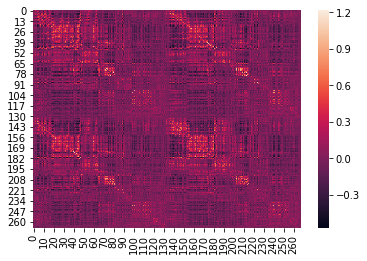

In [8]:
s = 0

sns.heatmap(sp.spatial.distance.squareform(all_fc_data.iloc[s,:]))
plt.show()

## Define CPM functions

In [9]:
def mk_kfold_indices(subj_list, k = 10):
    """
    Splits list of subjects into k folds for cross-validation.
    """
    
    n_subs = len(subj_list)
    n_subs_per_fold = n_subs//k # floor integer for n_subs_per_fold

    indices = [[fold_no]*n_subs_per_fold for fold_no in range(k)] # generate repmat list of indices
    remainder = n_subs % k # figure out how many subs are left over
    remainder_inds = list(range(remainder))
    indices = [item for sublist in indices for item in sublist]    
    [indices.append(ind) for ind in remainder_inds] # add indices for remainder subs

    assert len(indices)==n_subs, "Length of indices list does not equal number of subjects, something went wrong"

    np.random.shuffle(indices) # shuffles in place

    return np.array(indices)

In [10]:
def split_train_test(subj_list, indices, test_fold):
    """
    For a subj list, k-fold indices, and given fold, returns lists of train_subs and test_subs
    """

    train_inds = np.where(indices!=test_fold)
    test_inds = np.where(indices==test_fold)

    train_subs = []
    for sub in subj_list[train_inds]:
        train_subs.append(sub)

    test_subs = []
    for sub in subj_list[test_inds]:
        test_subs.append(sub)

    return (train_subs, test_subs)

In [11]:
def get_train_test_data(all_fc_data, train_subs, test_subs, behav_data, behav):

    """
    Extracts requested FC and behavioral data for a list of train_subs and test_subs
    """

    train_vcts = all_fc_data.loc[train_subs, :]
    test_vcts = all_fc_data.loc[test_subs, :]

    train_behav = behav_data.loc[train_subs, behav]

    return (train_vcts, train_behav, test_vcts)

In [12]:
def select_features(train_vcts, train_behav, r_thresh=0.2, corr_type='pearson', verbose=False):
    
    """
    Runs the CPM feature selection step: 
    - correlates each edge with behavior, and returns a mask of edges that are correlated above some threshold, one for each tail (positive and negative)
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    # Correlate all edges with behav vector
    if corr_type =='pearson':
        cov = np.dot(train_behav.T - train_behav.mean(), train_vcts - train_vcts.mean(axis=0)) / (train_behav.shape[0]-1)
        corr = cov / np.sqrt(np.var(train_behav, ddof=1) * np.var(train_vcts, axis=0, ddof=1))
    elif corr_type =='spearman':
        corr = []
        for edge in train_vcts.columns:
            r_val = sp.stats.spearmanr(train_vcts.loc[:,edge], train_behav)[0]
            corr.append(r_val)

    # Define positive and negative masks
    mask_dict = {}
    mask_dict["pos"] = corr > r_thresh
    mask_dict["neg"] = corr < -r_thresh
    
    if verbose:
        print("Found ({}/{}) edges positively/negatively correlated with behavior in the training set".format(mask_dict["pos"].sum(), mask_dict["neg"].sum())) # for debugging

    return mask_dict

In [13]:
def build_model(train_vcts, mask_dict, train_behav):
    """
    Builds a CPM model:
    - takes a feature mask, sums all edges in the mask for each subject, and uses simple linear regression to relate summed network strength to behavior
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    model_dict = {}

    # Loop through pos and neg tails
    X_glm = np.zeros((train_vcts.shape[0], len(mask_dict.items())))

    t = 0
    for tail, mask in mask_dict.items():
        X = train_vcts.values[:, mask].sum(axis=1)
        X_glm[:, t] = X
        y = train_behav
        (slope, intercept) = np.polyfit(X, y, 1)
        model_dict[tail] = (slope, intercept)
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    model_dict["glm"] = tuple(np.linalg.lstsq(X_glm, y, rcond=None)[0])

    return model_dict

In [14]:
def apply_model(test_vcts, mask_dict, model_dict):
    """
    Applies a previously trained linear regression model to a test set to generate predictions of behavior.
    """

    behav_pred = {}

    X_glm = np.zeros((test_vcts.shape[0], len(mask_dict.items())))

    # Loop through pos and neg tails
    t = 0
    for tail, mask in mask_dict.items():
        X = test_vcts.loc[:, mask].sum(axis=1)
        X_glm[:, t] = X

        slope, intercept = model_dict[tail]
        behav_pred[tail] = slope*X + intercept
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    behav_pred["glm"] = np.dot(X_glm, model_dict["glm"])

    return behav_pred

OK, now let's put all that together in a "wrapper" function that will go through and perform a full k-fold cross-validated CPM analysis:

In [15]:
def cpm_wrapper(all_fc_data, all_behav_data, behav, k=10, **cpm_kwargs):

    assert all_fc_data.index.equals(all_behav_data.index), "Row (subject) indices of FC vcts and behavior don't match!"

    subj_list = all_fc_data.index # get subj_list from df index
    
    indices = mk_kfold_indices(subj_list, k=k)
    
    # Initialize df for storing observed and predicted behavior
    col_list = []
    for tail in ["pos", "neg", "glm"]:
        col_list.append(behav + " predicted (" + tail + ")")
    col_list.append(behav + " observed")
    behav_obs_pred = pd.DataFrame(index=subj_list, columns = col_list)
    
    # Initialize array for storing feature masks
    n_edges = all_fc_data.shape[1]
    all_masks = {}
    all_masks["pos"] = np.zeros((k, n_edges))
    all_masks["neg"] = np.zeros((k, n_edges))
    
    for fold in range(k):
        print("doing fold {}".format(fold))
        train_subs, test_subs = split_train_test(subj_list, indices, test_fold=fold)
        train_vcts, train_behav, test_vcts = get_train_test_data(all_fc_data, train_subs, test_subs, all_behav_data, behav=behav)
        mask_dict = select_features(train_vcts, train_behav, **cpm_kwargs)
        all_masks["pos"][fold,:] = mask_dict["pos"]
        all_masks["neg"][fold,:] = mask_dict["neg"]
        model_dict = build_model(train_vcts, mask_dict, train_behav)
        behav_pred = apply_model(test_vcts, mask_dict, model_dict)
        for tail, predictions in behav_pred.items():
            behav_obs_pred.loc[test_subs, behav + " predicted (" + tail + ")"] = predictions
            
    behav_obs_pred.loc[subj_list, behav + " observed"] = all_behav_data[behav]
    
    return behav_obs_pred, all_masks

OK cool, now we can play around! First, let's choose a task condition to use and read in our FC matrices.

For this tutorial, you can choose from the following task conditions:
(see this paper for more details about each of the tasks: https://www.sciencedirect.com/science/article/abs/pii/S1053811913005272)

- Rest ( `REST` )
- Working memory ( `WM` )
- Language (`LANGUAGE`)
- Gambling (`GAMBLING`)
- Social (`SOCIAL`)


In [16]:
condition = 'REST'
all_fc_data = read_in_matrices(subj_list, file_suffix=condition)

Next, choose which behavior you'd like to predict. It's a good idea to look at a histogram to make sure there is actually variability across subjects, and the distribution isn't too skewed.

Here are some cognitive variables you might want to play around with:

- `PMAT24_A_CR`: Fluid intelligence (# items correct on Raven's progressive matrices task)
- `ListSort_Unadj`: Working memory (list sorting task)
- `PicVocab_Unadj`: Picture vocabulary (verbal IQ)
- `ReadEng_Unadj`: Reading (verbal IQ)
- `ProcSpeed_Unadj`: Processing speed
- `PicSeq_Unadj`: Episodic memory (picture sequence)
- `DDisc_AUC_40K`: Measure of delay discounting

And here are some emotion variables:
- `ER40_CR`: Performance on emotion recognition task

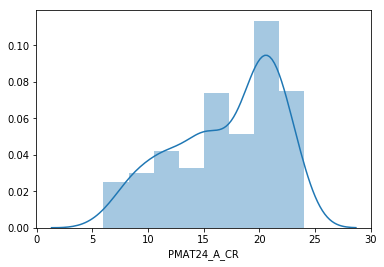

In [17]:
behav = 'PMAT24_A_CR'

sns.distplot(all_behav_data[behav])
plt.show()

See the HCP manual (specifically Chapter 5) for a list of what all the behavioral measures mean: https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf

Note that if your behavior is highly skewed (i.e., non-normally distributed), you should consider using Spearman (rank) correlation in the CPM feature selection step (you can do this by setting `corr_type` to `spearman` [default `pearson`] in the `cpm_kwargs` dictionary).

Now we run our CPM!

In [18]:
cpm_kwargs = {'r_thresh': 0.2, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit

behav_obs_pred, all_masks = cpm_wrapper(all_fc_data, all_behav_data, behav=behav, **cpm_kwargs)

doing fold 0
doing fold 1
doing fold 2
doing fold 3
doing fold 4
doing fold 5
doing fold 6
doing fold 7
doing fold 8
doing fold 9


In [19]:
behav_obs_pred.head()

,PMAT24_A_CR predicted (pos),PMAT24_A_CR predicted (neg),PMAT24_A_CR predicted (glm),PMAT24_A_CR observed
100206,18.9502,18.022,18.7115,20
100610,22.2026,18.5781,21.3101,23
101006,14.9591,15.3824,14.8414,11
101309,16.1487,16.539,16.2344,15
101915,18.8134,17.5992,18.4056,21


Now we'll make a function that makes pretty scatter plots of observed versus predicted behavior:

In [20]:
def plot_predictions(behav_obs_pred, tail="glm"):
    x = behav_obs_pred.filter(regex=("obs")).astype(float)
    y = behav_obs_pred.filter(regex=(tail)).astype(float)

    g = sns.regplot(x=x.T.squeeze(), y=y.T.squeeze(), color='gray')
    ax_min = min(min(g.get_xlim()), min(g.get_ylim()))
    ax_max = max(max(g.get_xlim()), max(g.get_ylim()))
    g.set_xlim(ax_min, ax_max)
    g.set_ylim(ax_min, ax_max)
    g.set_aspect('equal', adjustable='box')
    
    r = sp.stats.pearsonr(x,y)[0][0]
    g.annotate('r = {0:.2f}'.format(r), xy = (0.7, 0.1), xycoords = 'axes fraction')
    
    return g

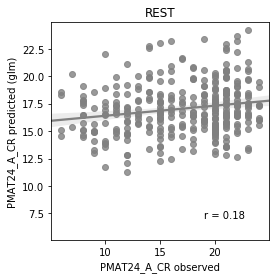

In [21]:
g = plot_predictions(behav_obs_pred)
g.set_title(condition)
plt.show()

### OK, let's put it all together:

In the next cell, play around with `condition` and `behav` to explore how FC measured during different conditions can predict different behaviors:

doing fold 0
doing fold 1
doing fold 2
doing fold 3
doing fold 4
doing fold 5
doing fold 6
doing fold 7
doing fold 8
doing fold 9


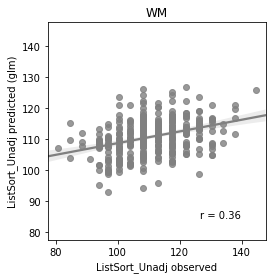

In [22]:
condition = 'WM'
behav = 'ListSort_Unadj'
cpm_kwargs = {'r_thresh': 0.2, 'corr_type': 'pearson', 'verbose': False}


all_fc_data = read_in_matrices(subj_list, file_suffix=condition)
behav_obs_pred, all_masks = cpm_wrapper(all_fc_data, all_behav_data, behav=behav, **cpm_kwargs)
g = plot_predictions(behav_obs_pred)
g.set_title(condition)
plt.show()

Some notes:

I deliberately didn't set a random seed for this notebook so that you could see that the results of CPM (and any cross-validated prediction or classification analysis!) can vary a bit each time you run them, due to variation in how subjects are stratified into folds. For this reason, it's recommended that you run several iterations of k-fold (i.e., at least 100, maybe more like 1,000) and plot the distribution of correlations between observed and predicted behavior, to make sure your results are relatively stable, before you interpret them.

Similarly, I deliberately didn't print any p-value associated with the r-value for correlation between predicted and observed scores. In cross-validated regression, it's not correct to interpret the parametric p-value, because the folds are not independent of one another. To assess the statistical significance of the accuracy of our model, we would need to calculate a non-parametric p-value by generating a null distribution of how well we expect to be able to predict behavior by chance. We'd do this by randomly shuffling subjects' behavior a large number of times (>= 1,000), rerunning the CPM pipeline, then compare the "true" r-value to this distribution of null r-values. 

## Visualize edges

Now that we've (hopefully!) trained a successful CPM, you'd probably like to know which edges are actually doing the predicting!

We can use `nilearn`'s helpful `plot_connectome` function to visualize this. Here we'll also use the `all_masks` variable that we spit out along with the predicted behavior from our CPM code above.

First we read in the MNI x-y-z coordinates of our nodes (the Shen atlas in this case):

In [23]:
shen268_coords = pd.read_csv("shen268_coords.csv", index_col="NodeNo")
print(shen268_coords.shape)
shen268_coords.head()

(268, 3)


,MNI_X,MNI_Y,MNI_Z
NodeNo,,,
1,13.9,56.8,-16.6
2,9.6,17.8,-19.5
3,5.1,34.9,-17.4
4,15.6,34.1,-22.6
5,8.2,45.9,-1.7


In [24]:
from nilearn.plotting import plot_connectome

/Users/finnes/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Now we define a function that will take in `all_masks`, calculate the consistency of each edge (i.e., how frequently it is selected across all k-fold iterations), and visualize only those edges that meet some consistency threshold (expressed as a percentage of times selected):

In [25]:
def plot_consistent_edges(all_masks, tail, thresh = 1., color='gray'):
    
    edge_frac = (all_masks[tail].sum(axis=0))/(all_masks[tail].shape[0])
    print("For the {} tail, {} edges were selected in at least {}% of folds".format(tail, (edge_frac>=thresh).sum(), thresh*100))
    edge_frac_square = sp.spatial.distance.squareform(edge_frac)

    node_mask = np.amax(edge_frac_square, axis=0) >= thresh # find nodes that have at least one edge that passes the threshold
    node_size = edge_frac_square.sum(axis=0)*node_mask*20 # size nodes based on how many suprathreshold edges they have

    plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                    node_color = color,
                    node_coords=shen268_coords, node_size=node_size,
                    display_mode= 'lzry',
                    edge_kwargs={"linewidth": 1, 'color': color})

For the pos tail, 39 edges were selected in at least 80.0% of folds


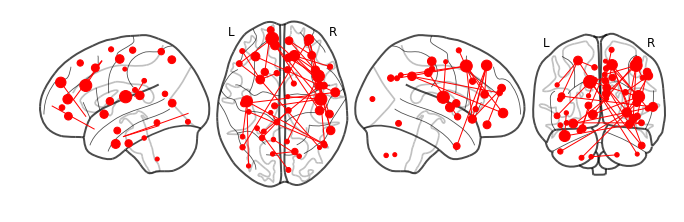

In [26]:
plot_consistent_edges(all_masks, "pos", thresh = 0.8, color = 'red')

For the neg tail, 41 edges were selected in at least 80.0% of folds


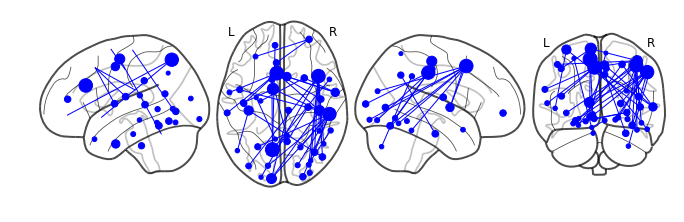

In [27]:
plot_consistent_edges(all_masks, "neg", thresh = 0.8, color = 'blue')

Hmm, interesting!

That's all for this tutorial for the moment. Hope it's been helpful!